<a href="https://colab.research.google.com/github/mo3az-14/Fashion-MNIST/blob/main/FASHION_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#0.Imports and helper functions

In [ ]:
import torch
from torch import nn
#vision
import torchvision
from torchvision import datasets , transforms
from torchvision.transforms import ToTensor
#plotting
import matplotlib.pyplot as plt

In [ ]:
#helper functions 
import requests 
from pathlib import Path
if Path("helper_functions.py").is_file() :
  print("helper functions already exists")
else: 
  print("downloading helper functions....")
  
  req = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py" , "wb") as f :
    f.write(req.content)
  print("done ! ")

downloading helper functions....
done ! 


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# 1.Getting a dataset

In [ ]:
# getting the data from the pytorch vision datasets
from torchvision import datasets

#training data
train_data = datasets.FashionMNIST(
    root = "data" , 
    train = True  ,
    download = True, 
    transform = ToTensor() ,
    target_transform= None ,
    )
#testing data
test_data = datasets.FashionMNIST(
    root = "data" , 
    train = False  , 
    download = True, 
    transform = ToTensor() ,
    target_transform= None ,
    )

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
class_names = train_data.classes

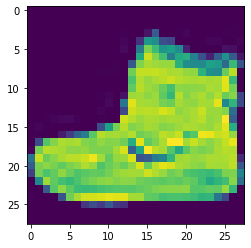

In [ ]:
image, label = train_data[0]
#print(f"Image Shape : {image} ") 
plt.imshow(image.squeeze()) 

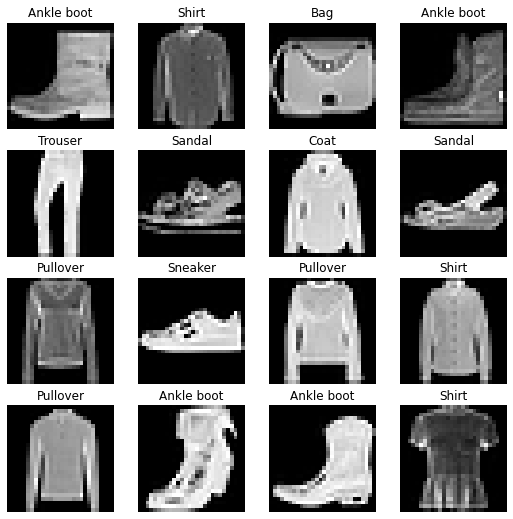

In [ ]:
torch.manual_seed(42) 
fig= plt.figure(figsize= (9,9))
rows , cols = 4,4 
for i in range(1, rows*cols+1) : 
  random_idx =torch.randint(0,len(train_data), size=[1]).item()
  img , label =train_data[random_idx]
  fig.add_subplot(rows,cols,i)
  plt.imshow(img.squeeze() , cmap="gray")
  plt.title(class_names[label])
  plt.axis(False)

# 2.prepare data loader 


In [ ]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data , batch_size= 32, shuffle = True)
test_dataloader = DataLoader(dataset=test_data , batch_size= 32, shuffle = False)
train_dataloader.dataset,test_dataloader.dataset

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(), Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [ ]:
# getting a random batch
train_features_batch , train_labels_batch = next(iter(train_dataloader))

(-0.5, 27.5, 27.5, -0.5)

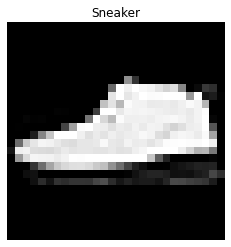

In [ ]:
#torch.manual_seed(42)
random_idx = torch.randint(0,len(train_features_batch) ,size=[1] ).item()
img , label = train_features_batch[random_idx] , train_labels_batch[random_idx]
plt.imshow(img.squeeze(),cmap="gray")
plt.title(class_names[label])
plt.axis(False)

# 3.Models training
it's a standard practice to start with a baseline model. A baseline model allows us to improve upon with subsequent models/experiments.


In [ ]:
# Create a flatten layer 
flat_layer = nn.Flatten()
X = train_features_batch
#flatten the sample 
output = flat_layer(X)
print(f"before{X.shape} , after{output.shape}")

beforetorch.Size([32, 1, 28, 28]) , aftertorch.Size([32, 784])


##3.1 model 0

In [ ]:
class FashionMNISTModelV0(nn.Module):
  def __init__(self , input_shape :int , hidden_units :int , output_shape :int):
       super().__init__()
       self.layer_stack = nn.Sequential(
           nn.Flatten() ,
           nn.Linear(in_features= input_shape , 
                     out_features= hidden_units),
           nn.Linear(in_features= hidden_units ,
                     out_features= output_shape)
       )

  def forward(self,x): 
    return self.layer_stack(x)

In [ ]:
torch.manual_seed(42)

model_0 = FashionMNISTModelV0(
    input_shape = 784,
    hidden_units = 10 ,
    output_shape = len(class_names)
).to("cpu")

In [ ]:
dummy_x = torch.rand([1,1,28,28])
model_0(dummy_x)

tensor([[-0.0315,  0.3171,  0.0531, -0.2525,  0.5959,  0.2112,  0.3233,  0.2694,
         -0.1004,  0.0157]], grad_fn=<AddmmBackward0>)

In [ ]:
from helper_functions import accuracy_fn
#setup loss function and optimizer 
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params =model_0.parameters() , lr = 0.1 )

In [ ]:
# importing the timeit library to measure speed
from timeit import  default_timer as timer 
def print_train_time( start:float ,
                      end  :float ,
                      device : torch.device = device):
  total_time = end - start
  print(f"train time on {device} = {total_time:.3f} seconds")

Training 
1. loop through epochs
2. loop through training batches , perform training step , calculate the training loss per batch  
3. loop through test batches , perform test step , calculate the test loss per batch
4. print what happening 
5. time it all 

In [ ]:
#tqdm for progress bars :d
from tqdm.auto import tqdm 
#set seed and timer 
torch.manual_seed(42)
train_time_start_cpu = timer()
#set epochs -> small for faster training time
epochs = 3 

for epoch in tqdm(range(epochs)) : 
  print(f"Epoch:{epoch} \n----")
  train_loss = 0
  for batch , (X, y) in enumerate(train_dataloader) : 
    model_0.train()
    y_pred = model_0(X)
    
    #loss 
    loss = loss_fn(y_pred , y)
    train_loss += loss #train loss accumlation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if batch %400 == 0 : 
      print(f"looked at {batch *len(X)}/ {len(train_dataloader.dataset)} ")
  train_loss /=len(train_dataloader)
  test_loss, test_acc = 0,0 
  model_0.eval()
  with torch.inference_mode() : 
    for X_test,y_test in test_dataloader : 
        test_pred = model_0(X_test)
        #loss
        test_loss += loss_fn(test_pred ,y_test)
        test_acc += accuracy_fn(y_true = y_test , y_pred= test_pred.argmax(dim=1))
    test_loss/= len(test_dataloader)
    test_acc /= len(test_dataloader)
  print(f"\n train loss: {train_loss:.4f} | test loss: {test_loss:.4f} , test accuracy: {test_acc: .2f}")

#calculate time
total_train_time_end_cpu = timer()
total_train_time_model_0= print_train_time(start = train_time_start_cpu , end=total_train_time_end_cpu , device= str(next(model_0.parameters()).device) )

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:0 
----
looked at 0/ 60000 
looked at 12800/ 60000 
looked at 25600/ 60000 
looked at 38400/ 60000 
looked at 51200/ 60000 

 train loss: 0.5904 | test loss: 0.5095 , test accuracy:  82.04
Epoch:1 
----
looked at 0/ 60000 
looked at 12800/ 60000 
looked at 25600/ 60000 
looked at 38400/ 60000 
looked at 51200/ 60000 

 train loss: 0.4763 | test loss: 0.4799 , test accuracy:  83.20
Epoch:2 
----
looked at 0/ 60000 
looked at 12800/ 60000 
looked at 25600/ 60000 
looked at 38400/ 60000 
looked at 51200/ 60000 

 train loss: 0.4550 | test loss: 0.4766 , test accuracy:  83.43
train time on cpu = 36.878 seconds


In [ ]:
# EVALUATION FUNCTION
torch.manual_seed(42)
def eval_model(model:torch.nn.Module,
               data_loader:torch.utils.data.DataLoader , 
               loss_fn:torch.nn.Module,
               accuracy_fn  , device ):
    loss, acc = 0 ,0 
    model.eval()
    with torch.inference_mode():
      for X,y  in data_loader : 
        X , y= X.to(device) , y.to(device)
        y_pred = model(X)
        #accumlate loss and accuracy values per batch 
        loss+= loss_fn(y_pred , y)
        acc += accuracy_fn(y_true = y ,y_pred = y_pred.argmax(dim=1))
      loss /= len(data_loader)
      acc /= len(data_loader)
    #returning a dictionary with the name of the model and it's performance
    return {"model_name" : model.__class__.__name__ , 
            "model_loss" : loss.item(),
            "model_acc": acc}
    

In [ ]:
model_0_results = eval_model(model= model_0 , loss_fn = loss_fn , data_loader = test_dataloader , accuracy_fn= accuracy_fn , device= "cpu") 

In [ ]:
!nvidia-smi

Tue Mar 28 18:49:07 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 3.2 model 1

In [ ]:
class FashionMNISTModelV1(nn.Module): 
  def __init__(self , in_features , out_features , hidden) : 
    super().__init__()
    self.layers = nn.Sequential( 
        nn.Flatten(), 
        nn.Linear(in_features = in_features , out_features=hidden), 
        nn.ReLU(),
        nn.Linear(in_features = hidden , out_features = out_features),
        nn.ReLU()
    )
  def forward(self,x): 
    return self.layers(x)

In [ ]:
model_1 = FashionMNISTModelV1(in_features=784, out_features= len(class_names) , hidden=8  ).to(device)

In [ ]:
# TRAINING FUNCTION
def train_step(model: torch.nn.Module , loss_fn :torch.nn , 
               optimizer : torch.optim , 
               data_loader :torch.utils.data.dataloader , 
               accuracy_fn   , device = device):
  train_loss , train_acc = 0,0
  model.train()
  for batch , (X, y) in enumerate(data_loader) : 
    X,y = X.to(device) , y.to(device)
    y_pred = model(X)
    #loss 
    loss = loss_fn(y_pred , y)
    train_loss += loss #train loss accumlation
    train_acc += accuracy_fn(y_true = y , y_pred = y_pred.argmax(dim=1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step() 
      
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train Loss : {train_loss:.5f} | Train Accuracy: {train_acc:.2f}% ")

In [ ]:
# TESTING FUNCTION
def test_step(model : torch.nn.Module,  
              loss_fn : torch.nn,
              data_loader: torch.utils.data.dataloader , 
              accuracy_fn , device = device): 
  test_loss , test_acc = 0,0
  model.eval()
  with torch.inference_mode(): 
    for X,y in data_loader : 
      X,y = X.to(device) ,y.to(device)
      y_pred = model(X)
      test_loss += loss_fn(y_pred , y)
      test_acc += accuracy_fn(y_true= y,  y_pred= y_pred.argmax(dim=1))
    
    test_loss /=len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.4f} | Test accuracy: {test_acc:.2f}%")

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params= model_1.parameters() , lr = 0.1)

In [ ]:
time_on_gpu_start = timer()
for epoch in tqdm(range(epochs)):
  print(f"Epoch {epoch+1} \n"+("-"*100))
  train_step(model_1 , loss_fn , optimizer , train_dataloader , accuracy_fn , device)
  test_step(model_1 , loss_fn   , test_dataloader , accuracy_fn , device)
time_on_gpu_end= timer()
timer_to_train_on_gpu = print_train_time(start =time_on_gpu_start , end = time_on_gpu_end , device= str(next(model_1.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1 
----------------------------------------------------------------------------------------------------
Train Loss : 1.11531 | Train Accuracy: 61.93% 
Test loss: 0.9436 | Test accuracy: 66.45%
Epoch 2 
----------------------------------------------------------------------------------------------------
Train Loss : 0.71300 | Train Accuracy: 76.15% 
Test loss: 0.6981 | Test accuracy: 76.86%
Epoch 3 
----------------------------------------------------------------------------------------------------
Train Loss : 0.67548 | Train Accuracy: 77.20% 
Test loss: 0.6746 | Test accuracy: 77.22%
train time on cuda:0 = 32.707 seconds


In [ ]:
model_1_results = eval_model(model = model_1 , loss_fn = loss_fn , data_loader =test_dataloader ,accuracy_fn=accuracy_fn , device = device  )
model_1_results

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.6746134161949158,
 'model_acc': 77.21645367412141}

## 3.2 model 2 (CNN)

Here we are using the Tiny VGG architecture from the CNN explainer website : https://poloclub.github.io/cnn-explainer/ 

In [ ]:
class FashionMNISTV2(nn.Module): 
  def __init__(self , input_shape : int, hidden_units :int , output_shape :int ): 
    super().__init__()
    self.conv_block1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape , out_channels = hidden_units , kernel_size= 3 , stride =1 , padding=1 ) , 
        nn.ReLU(), 
        nn.Conv2d(in_channels=hidden_units , out_channels = hidden_units , kernel_size= 3 , stride =1 , padding=1 ) , 
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block2 = nn.Sequential(
        nn.Conv2d(in_channels= hidden_units , out_channels=hidden_units , kernel_size = 3 , stride = 1 , padding=1 ),
        nn.ReLU(),
        nn.Conv2d(in_channels= hidden_units , out_channels=hidden_units , kernel_size = 3 , stride = 1 , padding=1 ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size= 2 )
    )
    self.classifier = nn.Sequential(
        nn.Flatten() , 
        nn.Linear(in_features= hidden_units*7*7 , out_features=output_shape ) , 
    )
  def forward(self, x ): 
    x=self.conv_block1(x)
    x = self.conv_block2(x)
    x=self.classifier(x)
    return x 

In [ ]:
model_2 = FashionMNISTV2(input_shape = 1 , hidden_units= 10 , output_shape=len(class_names)).to(device)

In [ ]:
torch.manual_seed(42)

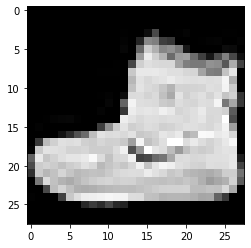

In [ ]:
plt.imshow(image.squeeze() , cmap="gray")

In [ ]:
loss_fn= nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters() , lr= 0.1)

In [ ]:
epochs = 3

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
train_time_for_model_2_cuda_s = timer()
for epoch in tqdm(range(epochs)) :
  train_step(model= model_2 , loss_fn = loss_fn , optimizer = optimizer , data_loader=train_dataloader , accuracy_fn = accuracy_fn , device =device)
  test_step(model= model_2 , loss_fn = loss_fn , data_loader=test_dataloader , accuracy_fn = accuracy_fn , device =device)


train_time_for_model_2_e = timer()
train_time_for_model_2  = print_train_time(device=device , start=train_time_for_model_2_cuda_s , end = train_time_for_model_2_e )
train_time_for_model_2

  0%|          | 0/3 [00:00<?, ?it/s]

Train Loss : 0.30634 | Train Accuracy: 88.90% 
Test loss: 0.3075 | Test accuracy: 88.94%
Train Loss : 0.29228 | Train Accuracy: 89.46% 
Test loss: 0.3213 | Test accuracy: 88.59%
Train Loss : 0.27959 | Train Accuracy: 89.92% 
Test loss: 0.2951 | Test accuracy: 89.70%
train time on cuda = 40.773 seconds


In [ ]:
model_2_res = eval_model(model=model_2 , loss_fn = loss_fn , data_loader=test_dataloader , device = device , accuracy_fn = accuracy_fn)
model_2_res

{'model_name': 'FashionMNISTV2',
 'model_loss': 0.29506516456604004,
 'model_acc': 89.6964856230032}

In [ ]:
#comparing results & putting them in dataframes
import pandas as pd
df = pd.DataFrame([model_0_results, model_1_results, model_2_res])

Text(0, 0.5, 'model (%)')

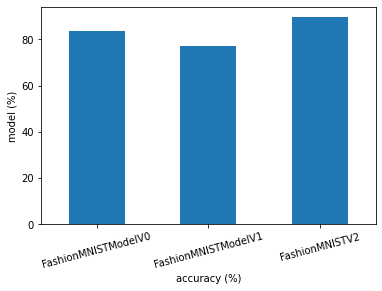

In [ ]:
#plotting models accuracys
df.set_index("model_name")['model_acc'].plot(kind="bar")
plt.xlabel("accuracy (%)" )
plt.xticks(rotation=15)
plt.ylabel("model (%)")

In [ ]:
def make_predictions(model: torch.nn.Module ,
                     data : list , 
                     device: torch.device = device): 
  pred_props = []
  model.to(device)
  model.eval()
  with torch.inference_mode(): 
    for sample in data : 
      #prepare the sample data for using by adding and additional batch dimension
      sample = torch.unsqueeze(sample, dim=0).to(device)
      #Forward pass (model outputs raw logits)
      pred_logits= model(sample)
      #get the prediction propablities 
      pred_prop = torch.softmax(pred_logits.squeeze() ,dim=0)
      pred_props.append(pred_prop.cpu()) 
  return torch.stack(pred_props)
  

In [ ]:
import random 
#random.seed(42)
test_sample= []
test_labels = []
for sample , label in random.sample(list(test_data) , k=9) :
  test_sample.append(sample)
  test_labels.append(label)
#view the first sample shape
test_sample[0].shape

torch.Size([1, 28, 28])

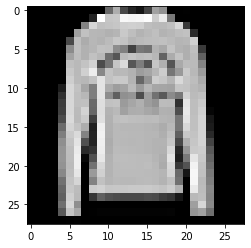

In [ ]:
plt.imshow(test_sample[0].squeeze(), cmap = 'gray')

In [ ]:
pred_props  = make_predictions(model= model_2 , data= test_sample )

In [ ]:
pred_classes= pred_props.argmax(dim=1)
pred_classes

tensor([2, 5, 4, 9, 8, 2, 8, 1, 0])

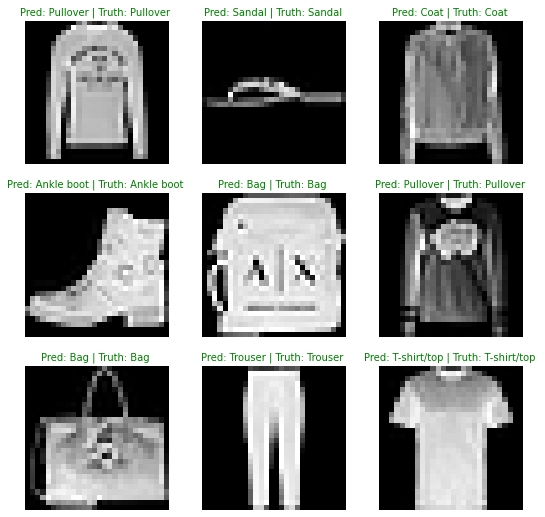

In [ ]:
plt.figure(figsize = (9,9))
nrows , ncols = 3,3
for i , sample in enumerate(test_sample ): 
  #create a subplot
  plt.subplot(nrows,ncols,i+1 )
  plt.imshow(sample.squeeze(),cmap='gray')
  #find the predictions in a human readable language 
  pred_label = class_names[pred_classes[i]]
  #true label
  truth_label = class_names[test_labels[i]]
  #create title
  title_text = f"Pred: {pred_label} | Truth: {truth_label} "
  #check for quality and change the color of the title accordingly
  if pred_label == truth_label: 
    plt.title(title_text , fontsize= 10 , c="g")
  else : 
    plt.title(title_text , fontsize= 10 , c="r")
  plt.axis(False)

#4.Making a confusion matrix for further prediction evaluation
  1.make predictions with our trained model on the test dataset 
  2.make a confusion matrix `torch.ConfusionMatrix` 
  3.plot the confusion matrix with `mlxtend.plotting.plot_confusion_matrix()`

In [ ]:
from tqdm.auto import tqdm

y_preds = []
model_2.eval()
with torch.inference_mode(): 
  for X , y in tqdm(test_dataloader , desc = "Making predictions..."):
    #sending data and predictions to target device
    X,y = X.to(device) , y.to(device)
  
    y_logits = model_2(X)
  
    y_pred = torch.softmax(y_logits.squeeze() , dim=1).argmax(dim=1)
    y_preds.append(y_pred.cpu()) 

y_pred_tensor= torch.cat(y_preds)
y_pred_tensor[:10]

Making predictions...:   0%|          | 0/313 [00:00<?, ?it/s]

tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7])

In [ ]:
#installing torchmetrics if not installed
try:
  import torchmetrics, mlxtend 
  print(f"mlxtend version : {mlxtend.__version__}")
  assert int(mlxtend.__version__.split(".")[1])>= 19 , "mlxtend version should be 0.19.0 or higher" 
except: 
  ! pip install -q torchmetrics -U mlxtend
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version : 0.21.0


In [ ]:
from torchmetrics.classification import MulticlassConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
confmat = MulticlassConfusionMatrix(num_classes=len(class_names) )
confmat_tensor = confmat(preds=y_pred_tensor ,target= test_data.targets )
confmat_tensor

tensor([[876,   2,  11,  26,   4,   2,  70,   0,   9,   0],
        [  5, 970,   1,  18,   2,   0,   3,   0,   1,   0],
        [ 18,   0, 789,  12,  91,   0,  88,   0,   2,   0],
        [ 16,   0,  10, 915,  33,   0,  25,   0,   1,   0],
        [  1,   2,  24,  27, 862,   0,  80,   0,   4,   0],
        [  0,   0,   0,   1,   0, 985,   0,   8,   0,   6],
        [144,   2,  40,  36,  74,   0, 687,   0,  17,   0],
        [  0,   0,   0,   0,   0,  27,   0, 950,   1,  22],
        [  2,   1,   0,   5,   5,   4,   4,   2, 977,   0],
        [  0,   0,   0,   0,   0,   8,   0,  31,   2, 959]])

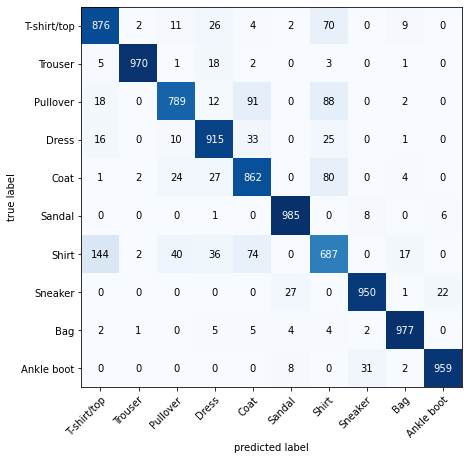

In [ ]:
fig, ax = plot_confusion_matrix(
    conf_mat = confmat_tensor.numpy() , 
    class_names= class_names,
  figsize=(10,7)
)